In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavanabm","key":"32d6c6e18ddaf2ec3e094108b64c435c"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d osamajalilhassan/bone-fracture-dataset


Dataset URL: https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset
License(s): unknown
 92% 158M/173M [00:00<00:00, 432MB/s] 
100% 173M/173M [00:00<00:00, 465MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import cv2
import pandas as pd
import time

In [7]:
DATADIR ='/content/BoneFractureDataset'
CATEGORIES = ['fractured','not_fractured']

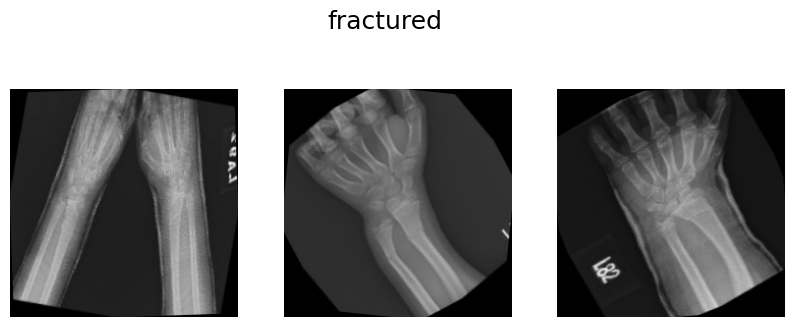

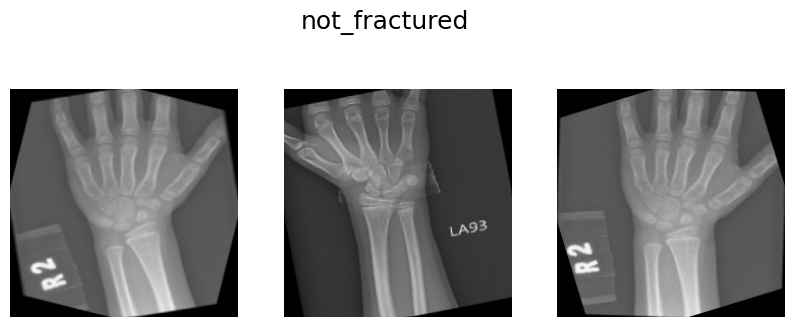

In [8]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, 'testing', category)  # or 'training' if you want to visualize training images
    images = os.listdir(path)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        ax[i].imshow(img_rgb)
        ax[i].axis('off')

    plt.show()

In [9]:
import os
import cv2

# Set the dataset directory and categories
DATADIR = '/content/BoneFractureDataset/training'  # Use training directory
CATEGORIES = ['fractured', 'not_fractured']
IMG_SIZE = 224 # Set your desired image size (e.g., 100x100)

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)  # Include the category folder (fractured/not_fractured)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # Resize image
                training_data.append([new_array, class_num])  # Append resized image and class number
            except Exception as e:
                pass  # In case of errors, just skip the image

create_training_data()
print(f"✅ Training samples: {len(training_data)}")


✅ Training samples: 8863


In [10]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert lists to NumPy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)



In [11]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'✅ X_train shape: {X_train.shape}')
print(f'✅ X_val shape:   {X_val.shape}')



✅ X_train shape: (7090, 224, 224, 3)
✅ X_val shape:   (1773, 224, 224, 3)


In [12]:
# Define test data directory
TESTDIR = '/content/BoneFractureDataset/testing'

# Initialize test data list
test_data = []

def create_test_data():
    for category in CATEGORIES:
        path = os.path.join(TESTDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                test_data.append([new_array, class_num])
            except Exception as e:
                pass

# Create the test data
create_test_data()

# Split features and labels
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)

# Convert to numpy arrays
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y_test = np.array(y_test)

# Normalize pixel values
X_test = X_test / 255.0

# Show shape
print(f'✅ X_test shape: {X_test.shape}')
print(f'✅ y_test shape: {y_test.shape}')


✅ X_test shape: (600, 224, 224, 3)
✅ y_test shape: (600,)


In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 142ms/step - accuracy: 0.7439 - loss: 0.5101 - val_accuracy: 0.9075 - val_loss: 0.2676
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9312 - loss: 0.2293 - val_accuracy: 0.9650 - val_loss: 0.1674
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9701 - loss: 0.1446 - val_accuracy: 0.9803 - val_loss: 0.1167
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9870 - loss: 0.0872 - val_accuracy: 0.9695 - val_loss: 0.0990
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9918 - loss: 0.0648 - val_accuracy: 0.9898 - val_loss: 0.0651
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9958 - loss: 0.0446 - val_accuracy: 0.9910 - val_loss: 0.0521
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9988 - loss: 0.0329 - val_accuracy: 0.9938 - val_loss: 0.0415
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/

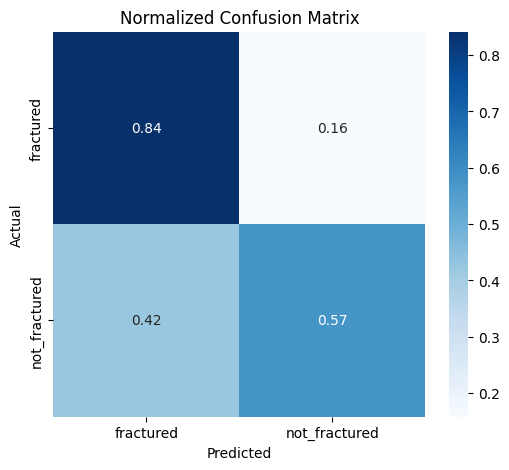


📊 Final ResNet50 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       1         9463           7090           600       ResNet50 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      10         0.0001            360824.24             0.9999               0.9955             0.735 0.0144           0.0264      0.732   0.735    0.7

In [16]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: ResNet50 Model ==========
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in resnet.layers:
    layer.trainable = False

model = keras.Sequential([
    resnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 1,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "ResNet50",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.0001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final ResNet50 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - accuracy: 0.7585 - loss: 0.6376 - val_accuracy: 0.9419 - val_loss: 0.1650
Epoch 2/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - accuracy: 0.9579 - loss: 0.1301 - val_accuracy: 0.9808 - val_loss: 0.0788
Epoch 3/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.9880 - loss: 0.0516 - val_accuracy: 0.9853 - val_loss: 0.0628
Epoch 4/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9908 - loss: 0.0347 - val_accuracy: 0.9915 - val_loss: 0.0320
Epoch 5/5
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.9970 - loss: 0.0157 - val_accuracy: 0.9893 - val_loss: 0.0284
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.7183 - loss: 0.6628
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step

📌 Classification Report:

               precision    recall  f1-score   support

    fractured       0.81      0.71      0.76       360
not_fractured       0.63      0.75      0.69       240

     ac

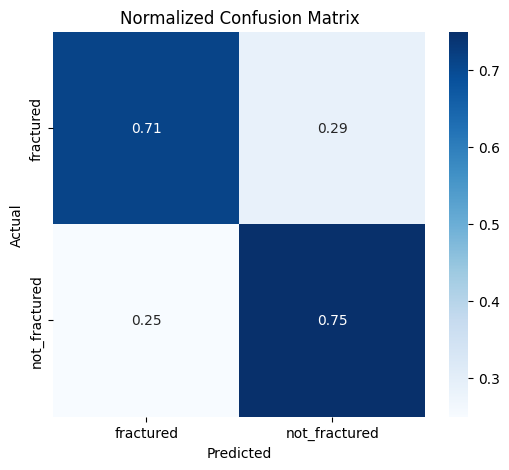


📊 Final ResNet50 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       1         9463           7090           600       ResNet50 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy       5          0.001            194025.97             0.9977               0.9893            0.7267 0.0137           0.0284     0.7396  0.7267    0.7

In [17]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: ResNet50 Model ==========
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in resnet.layers:
    layer.trainable = False

model = keras.Sequential([
    resnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 1,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "ResNet50",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 5,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final ResNet50 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - accuracy: 0.6827 - loss: 2.6148 - val_accuracy: 0.8878 - val_loss: 0.2593
Epoch 2/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.9141 - loss: 0.2148 - val_accuracy: 0.9447 - val_loss: 0.1398
Epoch 3/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.9742 - loss: 0.0747 - val_accuracy: 0.9633 - val_loss: 0.1002
Epoch 4/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.9740 - loss: 0.0721 - val_accuracy: 0.9729 - val_loss: 0.0599
Epoch 5/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9846 - loss: 0.0456 - val_accuracy: 0.9724 - val_loss: 0.0723
Epoch 6/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.9884 - loss: 0.0322 - val_accuracy: 0.9227 - val_loss: 0.2127
Epoch 7/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9775 - loss: 0.0576 - val_accuracy: 0.9820 - val_loss: 0.0425
Epoch 8/15
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step

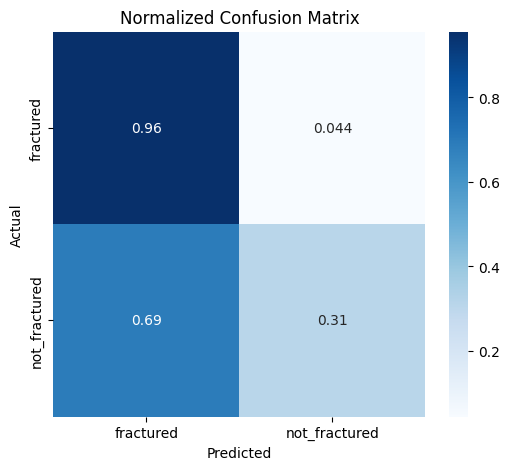


📊 Final ResNet50 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       1         9463           7090           600       ResNet50 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      15           0.01            508869.48             0.9927               0.9656            0.6967 0.0196           0.0996     0.7336  0.6967    0.6

In [18]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: ResNet50 Model ==========
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in resnet.layers:
    layer.trainable = False

model = keras.Sequential([
    resnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 1,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "ResNet50",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 15,
    "Learning Rate": 0.01,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final ResNet50 Summary:\n")
print(df_result.to_string(index=False))


✅ Training samples collected: 8863
Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - accuracy: 0.7506 - loss: 0.4957 - val_accuracy: 0.9233 - val_loss: 0.2541
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.9472 - loss: 0.2093 - val_accuracy: 0.9509 - val_loss: 0.1854
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.9624 - loss: 0.1423 - val_accuracy: 0.9797 - val_loss: 0.1135
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.9862 - loss: 0.0859 - val_accuracy: 0.9870 - val_loss: 0.0831
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.9947 - loss: 0.0576 - val_accuracy: 0.9904 - val_loss: 0.0661
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.9980 - loss: 0.0427 - val_accuracy: 0.9870 - val_loss: 0.0551
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9985 - loss: 0.0324 - val_accuracy: 0.9904 - val_loss: 0.0470
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step

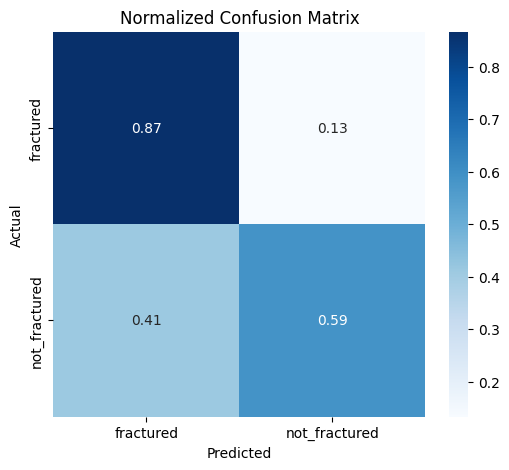


📊 Final ResNet50 Summary:

 SL. No.  Sample Size  Train Dataset  Test Dataset Proposed Model    Input Size  Hidden Layer Size Neurons in Hidden Layers Activation (Hidden)  Neurons (Output Layer) Activation (Output) Optimizer       Loss Function  Epochs  Learning Rate  Execution Time (ms)  Training Accuracy  Validation Accuracy  Testing Accuracy   Loss  Validation Loss  Precision  Recall  F1-score  Classification Miss Rate  Sensitivity  Specificity  F2-score  Fβ-score (β=0.5)  Positive Predicted Value  Negative Predicted Value  False Positive Ratio  False Negative Ratio  Likelihood Positive Ratio  Likelihood Negative Ratio
       1         9463           7090           600       ResNet50 (224, 224, 3)                  1                      512                relu                       1             sigmoid      Adam binary_crossentropy      10          0.001            343269.61             0.9999               0.9961             0.755 0.0138           0.0266     0.7539   0.755    0.7

In [19]:
# ========== STEP 1: Imports ==========
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# ========== STEP 2: Prepare Data ==========
DATADIR = "/content/BoneFractureDataset/training"
CATEGORIES = ["fractured", "not_fractured"]
IMG_SIZE = 224

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception:
                pass

create_training_data()
print(f"✅ Training samples collected: {len(training_data)}")

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# ========== STEP 3: Split Training into Train/Validation ==========
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ========== STEP 4: ResNet50 Model ==========
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in resnet.layers:
    layer.trainable = False

model = keras.Sequential([
    resnet,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# ========== STEP 5: Compile & Train ==========
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val)
)
exec_time = (time.time() - start_train_time) * 1000  # in ms

# ========== STEP 6: Load Test Data ==========
TEST_DIR = "/content/BoneFractureDataset/testing"
test_data = []

for category in CATEGORIES:
    path = os.path.join(TEST_DIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([new_array, class_num])
        except Exception:
            pass

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

# ========== STEP 7: Evaluation ==========
loss, test_acc = model.evaluate(X_test, y_test)
y_pred_prob = model.predict(X_test).ravel()
predictions = (y_pred_prob > 0.5).astype("int32")

print("\n📌 Classification Report:\n")
print(classification_report(y_test, predictions, target_names=CATEGORIES))

# ========== Confusion Matrix ==========
cf_matrix = confusion_matrix(y_test, predictions)
cf_norm = confusion_matrix(y_test, predictions, normalize='true')

plt.figure(figsize=(6, 5))
sns.heatmap(cf_norm, annot=True, cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ========== STEP 8: Metrics & Summary Table ==========
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
sensitivity = recall
specificity = np.mean(np.diag(cf_norm))
classification_miss_rate = 1 - test_acc

TP = np.diag(cf_matrix)
FP = np.sum(cf_matrix, axis=0) - TP
FN = np.sum(cf_matrix, axis=1) - TP
TN = np.sum(cf_matrix) - (TP + FP + FN)

PPV = TP / (TP + FP + 1e-10)
NPV = TN / (TN + FN + 1e-10)
FPR = FP / (FP + TN + 1e-10)
FNR = FN / (FN + TP + 1e-10)
LPR = PPV / (1 - FPR + 1e-10)
LNR = FNR / (1 - NPV + 1e-10)

PPV_avg = np.mean(PPV)
NPV_avg = np.mean(NPV)
FPR_avg = np.mean(FPR)
FNR_avg = np.mean(FNR)
LPR_avg = np.mean(LPR)
LNR_avg = np.mean(LNR)

f2 = fbeta_score(y_test, predictions, beta=2, average='weighted')
fbeta_custom = fbeta_score(y_test, predictions, beta=0.5, average='weighted')

# ========== STEP 9: Result Table ==========
result = {
    "SL. No.": 1,
    "Sample Size": len(X) + len(X_test),
    "Train Dataset": len(X_train),
    "Test Dataset": len(X_test),
    "Proposed Model": "ResNet50",
    "Input Size": X_train.shape[1:4],
    "Hidden Layer Size": 1,
    "Neurons in Hidden Layers": "512",
    "Activation (Hidden)": "relu",
    "Neurons (Output Layer)": 1,
    "Activation (Output)": "sigmoid",
    "Optimizer": "Adam",
    "Loss Function": "binary_crossentropy",
    "Epochs": 10,
    "Learning Rate": 0.001,
    "Execution Time (ms)": round(exec_time, 2),
    "Training Accuracy": round(train_acc, 4),
    "Validation Accuracy": round(val_acc, 4),
    "Testing Accuracy": round(test_acc, 4),
    "Loss": round(train_loss, 4),
    "Validation Loss": round(val_loss, 4),
    "Precision": round(precision, 4),
    "Recall": round(recall, 4),
    "F1-score": round(f1, 4),
    "Classification Miss Rate": round(classification_miss_rate, 4),
    "Sensitivity": round(sensitivity, 4),
    "Specificity": round(specificity, 4),
    "F2-score": round(f2, 4),
    "Fβ-score (β=0.5)": round(fbeta_custom, 4),
    "Positive Predicted Value": round(PPV_avg, 4),
    "Negative Predicted Value": round(NPV_avg, 4),
    "False Positive Ratio": round(FPR_avg, 4),
    "False Negative Ratio": round(FNR_avg, 4),
    "Likelihood Positive Ratio": round(LPR_avg, 4),
    "Likelihood Negative Ratio": round(LNR_avg, 4),
}

df_result = pd.DataFrame([result])
print("\n📊 Final ResNet50 Summary:\n")
print(df_result.to_string(index=False))


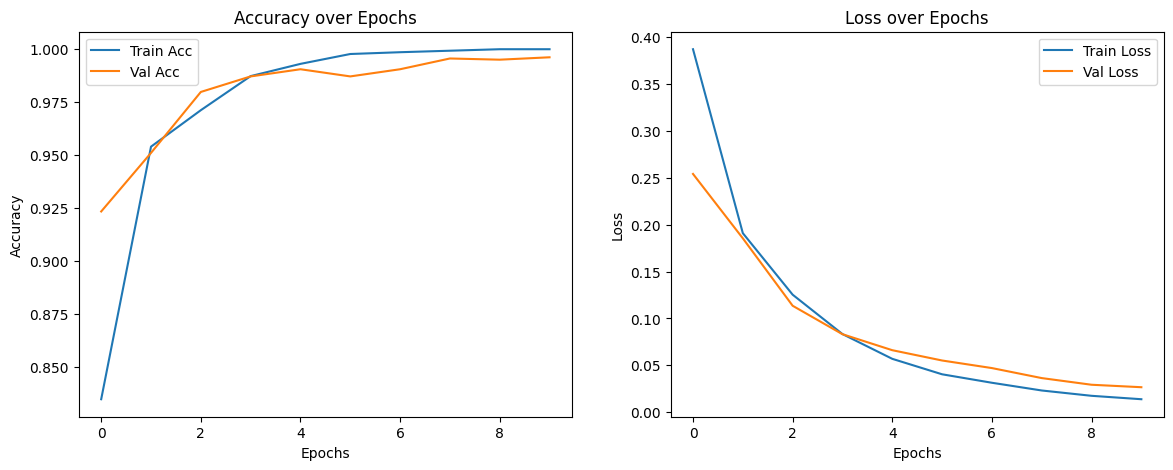

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


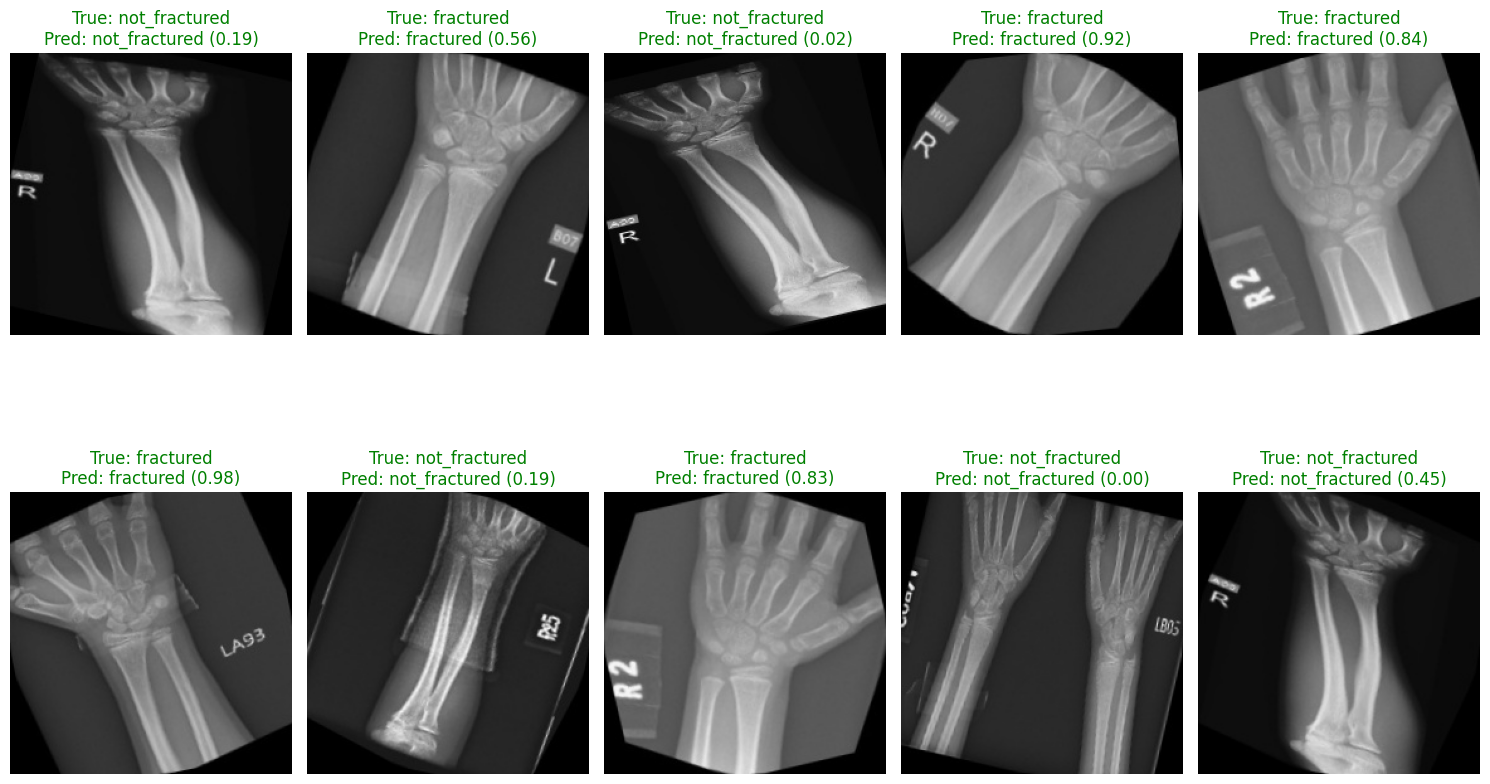

In [21]:
import random

# Map class index to label
class_labels = {0: "not_fractured", 1: "fractured"}

# Predict probabilities
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Show 10 random test images with predictions
plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})",
              color="green" if true_label == predicted_label else "red")
    plt.axis('off')

plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step

❌ Total wrong predictions: 147


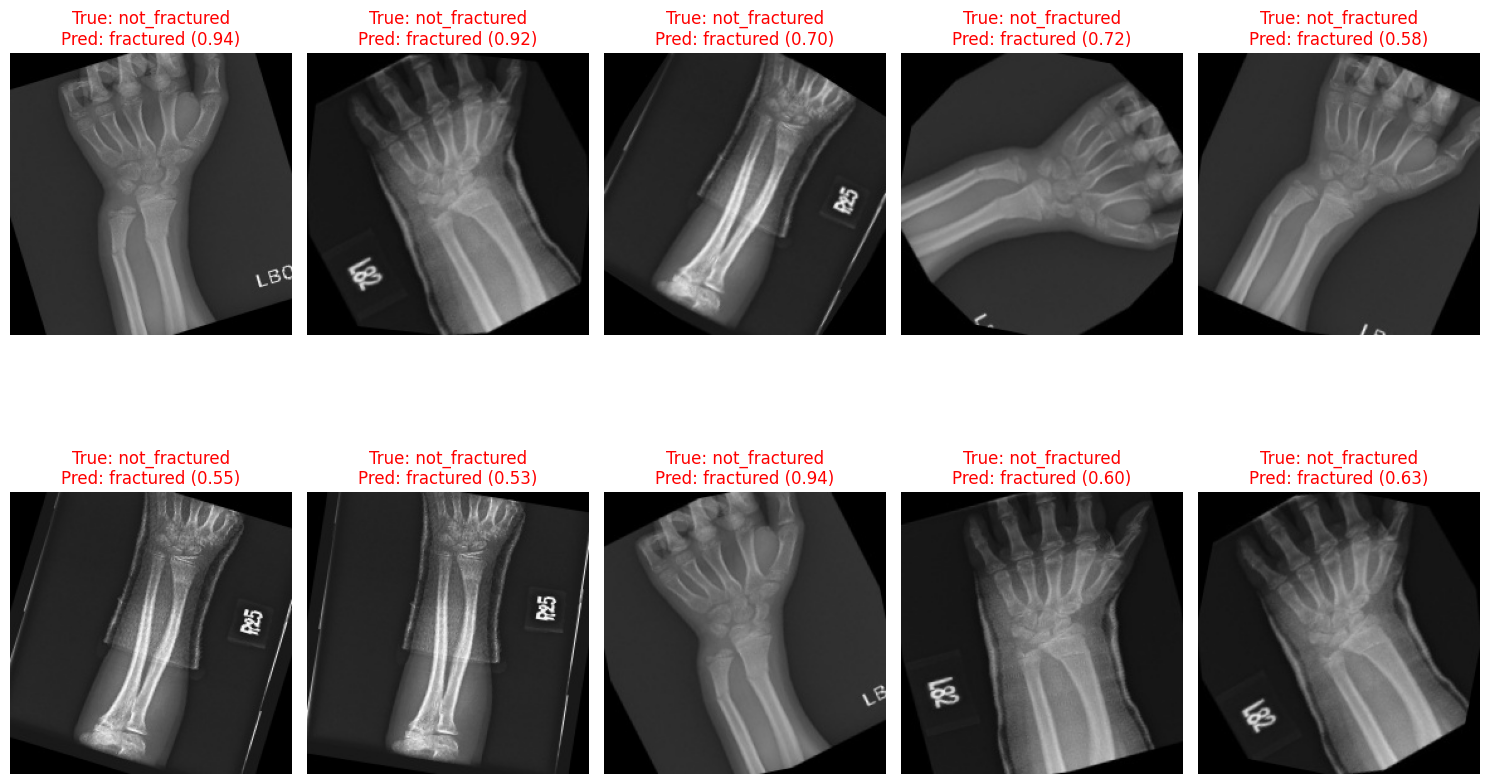

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_probs = model.predict(X_test)
y_preds = (y_probs > 0.5).astype("int32").flatten()

# Define label mapping
class_labels = {0: "not_fractured", 1: "fractured"}

# Find indices of incorrect predictions
wrong_indices = np.where(y_preds != y_test)[0]

print(f"\n❌ Total wrong predictions: {len(wrong_indices)}")

# Display some wrongly predicted images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(wrong_indices[:10]):  # Show first 10 wrong predictions
    img = X_test[idx]
    true_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_preds[idx]]
    prob = y_probs[idx][0]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"True: {true_label}\nPred: {predicted_label} ({prob:.2f})", color="red")
    plt.axis('off')

plt.tight_layout()
plt.show()


## **END OF ResNet50**
